# Correlation Between Draws 

In order to run the CVD model in 51 locations, we will need to limit the number of draws we use. One plan for doing this is selecting draws based on a much larger run in one state for use throughout the model. However, for that to work effectively the draws need to be correlated between state (e.g., the high draw in one state is also high in another state) even if they are different actual values. 

We will test in this notebook to see if that is actually true. 

### Starting with Incidence of AMI for Alabama, Washington and US 

I will use MEID 24694 which is AMI from IHD. While it is adjusted by prevalence in our model, I will not adjust it here since this is correlation.

In [1]:
import pandas as pd, numpy as np, os
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import matplotlib.pyplot as plt
import random
import scipy.stats

In [2]:
## This cell takes FOREVER to run, try and avoid, not needed for most of the workbook!! 

MI_inc = get_draws(release_id=6,
         year_id=2019,
         sex_id=2,
         location_id=523,
         age_group_id=18,
         gbd_id_type='modelable_entity_id',
         gbd_id=24694,
         measure_id=6,
         source='epi')

/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/get_draws/sources/epi.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["metric_id"] = gbd.metrics.RATE
/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id
/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/get_draws/base/utils.py:30: FutureWarning: In a future version of pandas, a length 1 tuple will be retur

In [3]:
data_a = MI_inc.set_index(['sex_id','modelable_entity_id','age_group_id'])
data_a = (data_a[[c for c in data_a.columns if 'draw' in c]].stack().reset_index()
        .rename(columns={'level_3':'draw',0:'value'}))
data_a = (data_a.pivot_table(index=['sex_id','age_group_id','draw'], columns='modelable_entity_id', values='value')
        .reset_index())
data_a = data_a.rename(columns={24694:'Alabama'})
#data_a.head()

In [ ]:
MI_inc = get_draws(release_id=6,
         year_id=2019,
         sex_id=2,
         location_id=570,
         age_group_id=18,
         gbd_id_type='modelable_entity_id',
         gbd_id=24694,
         measure_id=6,
         source='epi')

data_w = MI_inc.set_index(['sex_id','modelable_entity_id','age_group_id'])
data_w = (data_w[[c for c in data_w.columns if 'draw' in c]].stack().reset_index()
        .rename(columns={'level_3':'draw',0:'value'}))
data_w = (data_w.pivot_table(index=['sex_id','age_group_id','draw'], columns='modelable_entity_id', values='value')
        .reset_index())
data_w = data_w.rename(columns={24694:'Washington'})
#data_w.head()

In [ ]:
MI_inc = get_draws(release_id=6,
         year_id=2019,
         sex_id=2,
         location_id=102,
         age_group_id=18,
         gbd_id_type='modelable_entity_id',
         gbd_id=24694,
         measure_id=6,
         source='epi')

data_us = MI_inc.set_index(['sex_id','modelable_entity_id','age_group_id'])
data_us = (data_us[[c for c in data_us.columns if 'draw' in c]].stack().reset_index()
        .rename(columns={'level_3':'draw',0:'value'}))
data_us = (data_us.pivot_table(index=['sex_id','age_group_id','draw'], columns='modelable_entity_id', values='value')
        .reset_index())
data_us = data_us.rename(columns={24694:'US'})
#data_us.head()

In [ ]:
data_merged = data_a.merge(data_w[['draw','Washington']], on=['draw']).merge(data_us[['draw','US']], on=['draw'])
data_merged.head()

In [ ]:
a_w, p_val = scipy.stats.spearmanr(data_merged['Alabama'], data_merged['Washington'])
a_us, p_val = scipy.stats.spearmanr(data_merged['Alabama'], data_merged['US'])
us_w, p_val = scipy.stats.spearmanr(data_merged['Washington'], data_merged['US'])
print(a_w, a_us, us_w)

### Expanding to all locations

This seems like there is high correlation! But not 100% for all of them. Let's make sure this works for all of the states in a more systematic way. To simplify all of the possible correlations, I think we will compare all of the states to the full US.

In [2]:
MI_inc = get_draws(release_id=6,
         year_id=2019,
         sex_id=2,
         location_id=[102,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573],
         age_group_id=18,
         gbd_id_type='modelable_entity_id',
         gbd_id=24694,
         measure_id=6,
         source='epi')

In [4]:
MI_inc_edited = MI_inc.drop(['age_group_id','measure_id','sex_id','year_id','metric_id','model_version_id','modelable_entity_id'], axis=1)
MI_inc_edited = MI_inc_edited.transpose()
MI_inc_edited.columns = MI_inc_edited.iloc[1000]
MI_inc_edited = MI_inc_edited.drop(['location_id'], axis=0)
MI_inc_edited['102_rank'] = MI_inc_edited[102.0].rank(pct=True)
MI_inc_edited['523_rank'] = MI_inc_edited[523.0].rank(pct=True)
MI_inc_edited.head()

location_id,551.0,527.0,523.0,545.0,555.0,540.0,550.0,569.0,524.0,565.0,...,554.0,568.0,570.0,561.0,549.0,548.0,572.0,541.0,102_rank,523_rank
draw_0,0.003884,0.003264,0.004147,0.005876,0.005129,0.005259,0.003971,0.003450,0.003435,0.004376,...,0.003738,0.005422,0.003529,0.004332,0.003179,0.003991,0.003058,0.004608,0.169,0.237
draw_1,0.004394,0.003812,0.004249,0.006295,0.005307,0.005970,0.004418,0.004969,0.004257,0.004557,...,0.004485,0.005723,0.003971,0.005170,0.003872,0.005486,0.004367,0.004867,0.571,0.308
draw_10,0.004276,0.003235,0.003757,0.006267,0.005128,0.004860,0.003952,0.004480,0.003317,0.004659,...,0.003752,0.004825,0.003554,0.004554,0.003438,0.004361,0.003859,0.003960,0.228,0.077
draw_100,0.004797,0.003837,0.004705,0.006747,0.006736,0.006180,0.005205,0.004979,0.004668,0.005288,...,0.004786,0.006463,0.003942,0.005322,0.004396,0.005620,0.004368,0.006302,0.797,0.618
draw_101,0.004984,0.003937,0.005225,0.007327,0.005915,0.005884,0.004597,0.005158,0.004653,0.005333,...,0.004365,0.005909,0.004126,0.005256,0.003918,0.006125,0.004441,0.005554,0.786,0.878


In [5]:
a_w, p_val = scipy.stats.spearmanr(MI_inc_edited['102_rank'], MI_inc_edited['523_rank'])
print(a_w, p_val)

0.9066843066843068 0.0


In [6]:
df = pd.DataFrame()
for i in range(51): 
    corr, p_val = scipy.stats.spearmanr(MI_inc_edited.iloc[:,i], MI_inc_edited[102.0])
    data = pd.DataFrame(columns = ['corr','p_val'])
    data.loc[i,'corr'] = corr
    data.loc[i,'p_val'] = p_val
    df = pd.concat([df,data])

df

,corr,p_val
0,0.896026,0.0
1,0.897285,0.0
2,0.906684,0.0
3,0.875086,0.0
4,0.898085,0.0
5,0.927159,0.0
6,0.889075,0.0
7,0.897843,0.0
8,0.862419,0.0
9,0.876381,0.0


In [7]:
min(df['corr'])

0.8615414255414257

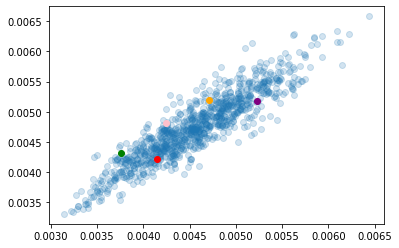

In [10]:
plt.scatter(MI_inc_edited[523.0][5:,], MI_inc_edited[102.0][5:,], alpha=0.2)
plt.scatter(MI_inc_edited[523.0][0], MI_inc_edited[102.0][0], c='red')
plt.scatter(MI_inc_edited[523.0][1], MI_inc_edited[102.0][1], c='pink')
plt.scatter(MI_inc_edited[523.0][2], MI_inc_edited[102.0][2], c='green')
plt.scatter(MI_inc_edited[523.0][3], MI_inc_edited[102.0][3], c='orange')
plt.scatter(MI_inc_edited[523.0][4], MI_inc_edited[102.0][4], c='purple')

Seems like they are highly correlated! The lowest correlation value is 0.86 which is still pretty high. This is a promising sign. 

## Checking with Randomization 

To ensure that what I am seeing is real and not just related to the relatively small interval of all the data - I will randomize the order for some of the rows and test again 

In [92]:
test_data = MI_inc_edited.iloc[:,0:1]
test_data1 = test_data.sample(frac = 1).reset_index(drop=True)
test_data1 = test_data1.rename(columns={102.0:'102_shuffled'})
test_data1.head()

location_id,102_shuffled
0,0.005301
1,0.005900
2,0.004402
3,0.004786
4,0.004984


In [93]:
a_w, p_val = scipy.stats.spearmanr(MI_inc_edited[102.0], test_data1['102_shuffled'])
print(a_w, p_val)

0.008543840748892926 0.7872779835767477


In [94]:
len(MI_inc_edited[102.0])

1000

In [95]:
len(test_data1['102_shuffled'])

1000

### Testing a few other data types 

It is impractical for me to test all of the input data sources.I will test a couple more to ensure this is consistent across different types of data. I did incidence before. I will test a RR value, a mean risk factor value and a risk standard deviation value.

To start with, I will do the RR value for BMI to MI.

In [11]:
BMI_MI_RR = get_draws(gbd_round_id=6,
         year_id=2019,
         sex_id=2,
         location_id=[102,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573],
         age_group_id=18,
         gbd_id_type='rei_id',
         gbd_id=370,
         source='rr',
         status='best',
         decomp_step='step4')

/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id
/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/sources/rr.py:239: UserWarning: RRs draws returned for rei_id = 370 have location_id(s) = 64 where 102, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573 were requested.
  warnings.warn(


Seems like it is by definition the same for all regions. 

## Prevalence

In [12]:
MI_prev = get_draws(release_id=6,
         year_id=2019,
         sex_id=2,
         location_id=[102,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573],
         age_group_id=18,
         gbd_id_type='modelable_entity_id',
         gbd_id=24694,
         measure_id=5,
         source='epi')

/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/sources/epi.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["metric_id"] = gbd.metrics.RATE
/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


In [15]:
MI_prev_edited = MI_prev.drop(['age_group_id','measure_id','sex_id','year_id','metric_id','model_version_id','modelable_entity_id'], axis=1)
MI_prev_edited = MI_prev_edited.transpose()
MI_prev_edited.columns = MI_prev_edited.iloc[1000]
MI_prev_edited = MI_prev_edited.drop(['location_id'], axis=0)
MI_prev_edited.head()

location_id,551.0,527.0,523.0,545.0,555.0,540.0,550.0,569.0,524.0,565.0,...,546.0,553.0,554.0,568.0,570.0,561.0,549.0,548.0,572.0,541.0
draw_0,0.000260,0.000223,0.000278,0.000400,0.000350,0.000350,0.000272,0.000235,0.000236,0.000292,...,0.000278,0.000276,0.000253,0.000365,0.000241,0.000291,0.000214,0.000269,0.000209,0.000301
draw_1,0.000274,0.000246,0.000268,0.000392,0.000330,0.000366,0.000281,0.000307,0.000268,0.000278,...,0.000270,0.000306,0.000283,0.000362,0.000250,0.000322,0.000246,0.000346,0.000278,0.000303
draw_10,0.000272,0.000212,0.000237,0.000393,0.000331,0.000300,0.000258,0.000283,0.000213,0.000296,...,0.000271,0.000283,0.000239,0.000309,0.000228,0.000286,0.000221,0.000276,0.000249,0.000246
draw_100,0.000320,0.000265,0.000311,0.000452,0.000449,0.000407,0.000352,0.000331,0.000316,0.000355,...,0.000352,0.000376,0.000325,0.000435,0.000268,0.000356,0.000296,0.000380,0.000294,0.000410
draw_101,0.000330,0.000269,0.000343,0.000482,0.000399,0.000384,0.000313,0.000346,0.000311,0.000351,...,0.000326,0.000346,0.000294,0.000396,0.000281,0.000349,0.000268,0.000405,0.000301,0.000359


In [16]:
df = pd.DataFrame()
for i in range(51): 
    corr, p_val = scipy.stats.spearmanr(MI_prev_edited.iloc[:,i], MI_prev_edited[102.0])
    data = pd.DataFrame(columns = ['corr','p_val'])
    data.loc[i,'corr'] = corr
    data.loc[i,'p_val'] = p_val
    df = pd.concat([df,data])

df

,corr,p_val
0,0.901046,0.0
1,0.895695,0.0
2,0.910786,0.0
3,0.872418,0.0
4,0.898686,0.0
5,0.926889,0.0
6,0.893177,0.0
7,0.899654,0.0
8,0.864256,0.0
9,0.884796,0.0


In [17]:
min(df['corr'])

0.8635026429894089

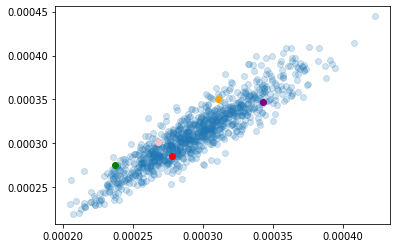

In [19]:
plt.scatter(MI_prev_edited[523.0][5:,], MI_prev_edited[102.0][5:,], alpha=0.2)
plt.scatter(MI_prev_edited[523.0][0], MI_prev_edited[102.0][0], c='red')
plt.scatter(MI_prev_edited[523.0][1], MI_prev_edited[102.0][1], c='pink')
plt.scatter(MI_prev_edited[523.0][2], MI_prev_edited[102.0][2], c='green')
plt.scatter(MI_prev_edited[523.0][3], MI_prev_edited[102.0][3], c='orange')
plt.scatter(MI_prev_edited[523.0][4], MI_prev_edited[102.0][4], c='purple')


## Mortality Data

In [31]:
stroke_csmr = get_draws(release_id=6,
         year_id=2019,
         sex_id=2,
         location_id=[102,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573],
         age_group_id=18,
         gbd_id_type='modelable_entity_id',
         gbd_id=3952,
         measure_id=15,
         source='epi')

/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/sources/epi.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["metric_id"] = gbd.metrics.RATE
/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


In [22]:
stroke_csmr_edited = stroke_csmr.loc[stroke_csmr.measure_id==15]
stroke_csmr_edited = stroke_csmr_edited.drop(['age_group_id','measure_id','sex_id','year_id','metric_id','model_version_id','modelable_entity_id'], axis=1)
stroke_csmr_edited = stroke_csmr_edited.transpose()
stroke_csmr_edited.columns = stroke_csmr_edited.iloc[1000]
stroke_csmr_edited = stroke_csmr_edited.drop(['location_id'], axis=0)
stroke_csmr_edited.head()

location_id,551.0,527.0,523.0,545.0,555.0,540.0,550.0,569.0,524.0,565.0,...,546.0,553.0,554.0,568.0,570.0,561.0,549.0,548.0,572.0,541.0
draw_0,0.000128,0.000114,0.000141,0.000127,0.000120,0.000128,0.000108,0.000129,0.000121,0.000131,...,0.000115,0.000105,0.000129,0.000103,0.000098,0.000121,0.000121,0.000123,0.000105,0.000120
draw_1,0.000116,0.000097,0.000123,0.000116,0.000107,0.000127,0.000106,0.000119,0.000108,0.000124,...,0.000097,0.000106,0.000113,0.000098,0.000098,0.000112,0.000098,0.000117,0.000096,0.000126
draw_10,0.000120,0.000094,0.000138,0.000107,0.000124,0.000140,0.000125,0.000103,0.000107,0.000112,...,0.000090,0.000101,0.000101,0.000117,0.000111,0.000104,0.000104,0.000108,0.000109,0.000127
draw_100,0.000069,0.000054,0.000081,0.000058,0.000056,0.000080,0.000065,0.000074,0.000062,0.000059,...,0.000052,0.000064,0.000064,0.000057,0.000065,0.000071,0.000062,0.000062,0.000062,0.000073
draw_101,0.000126,0.000105,0.000129,0.000118,0.000120,0.000142,0.000108,0.000123,0.000119,0.000140,...,0.000094,0.000107,0.000116,0.000105,0.000115,0.000133,0.000120,0.000137,0.000097,0.000135


In [23]:
df = pd.DataFrame()
for i in range(51): 
    corr, p_val = scipy.stats.spearmanr(stroke_csmr_edited.iloc[:,i], stroke_csmr_edited[102.0])
    data = pd.DataFrame(columns = ['corr','p_val'])
    data.loc[i,'corr'] = corr
    data.loc[i,'p_val'] = p_val
    df = pd.concat([df,data])

df

,corr,p_val
0,0.950105,0.0
1,0.950336,0.0
2,0.941401,0.0
3,0.956618,0.0
4,0.946488,0.0
5,0.946504,0.0
6,0.942529,0.0
7,0.957067,0.0
8,0.950819,0.0
9,0.948486,0.0


In [24]:
min(df['corr'])

0.9412607371547278

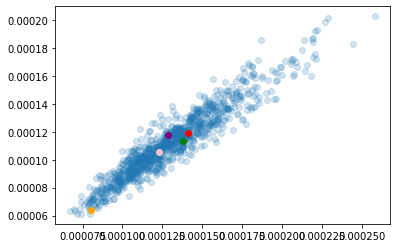

In [25]:
plt.scatter(stroke_csmr_edited[523.0][5:,], stroke_csmr_edited[102.0][5:,], alpha=0.2)
plt.scatter(stroke_csmr_edited[523.0][0], stroke_csmr_edited[102.0][0], c='red')
plt.scatter(stroke_csmr_edited[523.0][1], stroke_csmr_edited[102.0][1], c='pink')
plt.scatter(stroke_csmr_edited[523.0][2], stroke_csmr_edited[102.0][2], c='green')
plt.scatter(stroke_csmr_edited[523.0][3], stroke_csmr_edited[102.0][3], c='orange')
plt.scatter(stroke_csmr_edited[523.0][4], stroke_csmr_edited[102.0][4], c='purple')


Looks like they are not correlated between say, stroke and MI. But looks like they are correlated within MI. Checking that they are similarly correlated within stroke. 

## Stroke Incidence 

In [36]:
stroke_inc = get_draws(release_id=6,
         year_id=2019,
         sex_id=2,
         location_id=[102,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573],
         age_group_id=18,
         gbd_id_type='modelable_entity_id',
         gbd_id=3952,
         measure_id=6,
         source='epi')

In [37]:
stroke_inc_edited = stroke_inc.loc[stroke_inc.measure_id==6]
stroke_inc_edited = stroke_inc_edited.drop(['age_group_id','measure_id','sex_id','year_id','metric_id','model_version_id','modelable_entity_id'], axis=1)
stroke_inc_edited = stroke_inc_edited.transpose()
stroke_inc_edited.columns = stroke_inc_edited.iloc[1000]
stroke_inc_edited = stroke_inc_edited.drop(['location_id'], axis=0)
stroke_inc_edited.head()

location_id,551.0,527.0,523.0,545.0,555.0,540.0,550.0,569.0,524.0,565.0,...,546.0,553.0,554.0,568.0,570.0,561.0,549.0,548.0,572.0,541.0
draw_0,0.001944,0.001812,0.002106,0.002020,0.001878,0.001931,0.001932,0.001901,0.001909,0.001969,...,0.001851,0.001841,0.001849,0.001649,0.001666,0.001783,0.001844,0.001790,0.001697,0.001846
draw_1,0.002296,0.002156,0.002311,0.002193,0.002206,0.002291,0.002246,0.002322,0.002110,0.002373,...,0.002176,0.002248,0.002274,0.002002,0.002143,0.002182,0.002160,0.002314,0.002076,0.002265
draw_10,0.002085,0.001796,0.002335,0.001867,0.001905,0.001901,0.001927,0.001828,0.001908,0.001868,...,0.001790,0.001876,0.001870,0.001791,0.001752,0.001844,0.001890,0.001888,0.002025,0.002077
draw_100,0.001173,0.001090,0.001340,0.001187,0.001227,0.001326,0.001202,0.001258,0.001142,0.001200,...,0.001144,0.001184,0.001168,0.001114,0.001187,0.001239,0.001128,0.001255,0.001119,0.001197
draw_101,0.001966,0.001780,0.002085,0.001879,0.001881,0.002049,0.001821,0.001930,0.001871,0.002066,...,0.001824,0.001981,0.001939,0.001847,0.001863,0.002011,0.001832,0.002053,0.001823,0.001962


In [38]:
df = pd.DataFrame()
for i in range(51): 
    corr, p_val = scipy.stats.spearmanr(stroke_inc_edited.iloc[:,i], stroke_inc_edited[102.0])
    data = pd.DataFrame(columns = ['corr','p_val'])
    data.loc[i,'corr'] = corr
    data.loc[i,'p_val'] = p_val
    df = pd.concat([df,data])
df.head()

,corr,p_val
0,0.961165,0.0
1,0.960472,0.0
2,0.942389,0.0
3,0.966178,0.0
4,0.960206,0.0


In [39]:
min(df['corr'])

0.9423888063888065

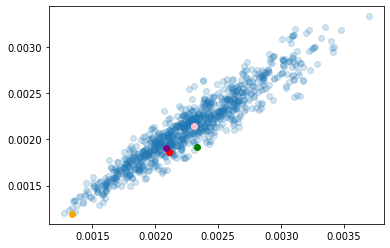

In [40]:
plt.scatter(stroke_inc_edited[523.0][5:,], stroke_inc_edited[102.0][5:,], alpha=0.2)
plt.scatter(stroke_inc_edited[523.0][0], stroke_inc_edited[102.0][0], c='red')
plt.scatter(stroke_inc_edited[523.0][1], stroke_inc_edited[102.0][1], c='pink')
plt.scatter(stroke_inc_edited[523.0][2], stroke_inc_edited[102.0][2], c='green')
plt.scatter(stroke_inc_edited[523.0][3], stroke_inc_edited[102.0][3], c='orange')
plt.scatter(stroke_inc_edited[523.0][4], stroke_inc_edited[102.0][4], c='purple')

## SBP Means

In [41]:
sbp_mean = get_draws(release_id=6,
         year_id=2019,
         sex_id=2,
         location_id=[102,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573],
         age_group_id=18,
         gbd_id_type='modelable_entity_id',
         gbd_id=2547,
         source='stgpr')

In [42]:
sbp_mean_edited = sbp_mean.drop(['age_group_id','measure_id','sex_id','year_id','stgpr_model_version_id','modelable_entity_id'], axis=1)
sbp_mean_edited = sbp_mean_edited.transpose()
sbp_mean_edited.columns = sbp_mean_edited.iloc[1000]
sbp_mean_edited = sbp_mean_edited.drop(['location_id'], axis=0)
#sbp_mean_edited

In [43]:
df = pd.DataFrame()
for i in range(51): 
    corr, p_val = scipy.stats.spearmanr(sbp_mean_edited.iloc[:,i], sbp_mean_edited[102.0])
    data = pd.DataFrame(columns = ['corr','p_val'])
    data.loc[i,'corr'] = corr
    data.loc[i,'p_val'] = p_val
    df = pd.concat([df,data])

df

,corr,p_val
0,0.476898,0.0
1,0.461254,0.0
2,0.455735,0.0
3,0.504375,0.0
4,1.0,0.0
5,0.484042,0.0
6,0.498576,0.0
7,0.500265,0.0
8,0.510036,0.0
9,0.461336,0.0


In [44]:
min(df['corr'])

0.4153212433212433

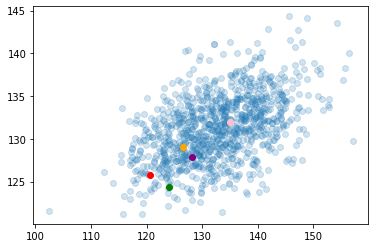

In [45]:
plt.scatter(sbp_mean_edited[523.0][5:,], sbp_mean_edited[102.0][5:,], alpha=0.2)
plt.scatter(sbp_mean_edited[523.0][0], sbp_mean_edited[102.0][0], c='red')
plt.scatter(sbp_mean_edited[523.0][1], sbp_mean_edited[102.0][1], c='pink')
plt.scatter(sbp_mean_edited[523.0][2], sbp_mean_edited[102.0][2], c='green')
plt.scatter(sbp_mean_edited[523.0][3], sbp_mean_edited[102.0][3], c='orange')
plt.scatter(sbp_mean_edited[523.0][4], sbp_mean_edited[102.0][4], c='purple')

Wow that is way more different than I was anticipating. 

Also doing FPG Means for fun

## FPG Mean

In [46]:
fpg_mean = get_draws(release_id=6,
         year_id=2019,
         sex_id=2,
         location_id=[102,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573],
         age_group_id=18,
         gbd_id_type='modelable_entity_id',
         gbd_id=8909,
         source='stgpr')

In [47]:
fpg_mean_edited = fpg_mean.drop(['age_group_id','measure_id','sex_id','year_id','stgpr_model_version_id','modelable_entity_id'], axis=1)
fpg_mean_edited = fpg_mean_edited.transpose()
fpg_mean_edited.columns = fpg_mean_edited.iloc[1000]
fpg_mean_edited = fpg_mean_edited.drop(['location_id'], axis=0)
#fpg_mean_edited

In [48]:
df = pd.DataFrame()
for i in range(51): 
    corr, p_val = scipy.stats.spearmanr(fpg_mean_edited.iloc[:,i], fpg_mean_edited[102.0])
    data = pd.DataFrame(columns = ['corr','p_val'])
    data.loc[i,'corr'] = corr
    data.loc[i,'p_val'] = p_val
    df = pd.concat([df,data])

df

,corr,p_val
0,0.588173,0.0
1,0.591482,0.0
2,0.602694,0.0
3,0.639782,0.0
4,1.0,0.0
5,0.611581,0.0
6,0.634271,0.0
7,0.605679,0.0
8,0.623144,0.0
9,0.590784,0.0


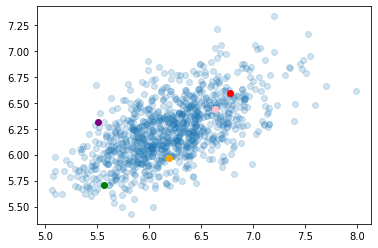

In [49]:
plt.scatter(fpg_mean_edited[523.0][5:,], fpg_mean_edited[102.0][5:,], alpha=0.2)
plt.scatter(fpg_mean_edited[523.0][0], fpg_mean_edited[102.0][0], c='red')
plt.scatter(fpg_mean_edited[523.0][1], fpg_mean_edited[102.0][1], c='pink')
plt.scatter(fpg_mean_edited[523.0][2], fpg_mean_edited[102.0][2], c='green')
plt.scatter(fpg_mean_edited[523.0][3], fpg_mean_edited[102.0][3], c='orange')
plt.scatter(fpg_mean_edited[523.0][4], fpg_mean_edited[102.0][4], c='purple')

### SBP Standard Deviaiton

In [50]:
sbp_std = get_draws(release_id=6,
         year_id=2019,
         sex_id=2,
         location_id=[102,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573],
         age_group_id=18,
         gbd_id_type='modelable_entity_id',
         gbd_id=15788,
         source='epi')

/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


In [52]:
sbp_std_edited = sbp_std.drop(['age_group_id','measure_id','metric_id','sex_id','year_id','model_version_id','modelable_entity_id'], axis=1)
sbp_std_edited = sbp_std_edited.transpose()
sbp_std_edited.columns = sbp_std_edited.iloc[1000]
sbp_std_edited = sbp_std_edited.drop(['location_id'], axis=0)
#sbp_std_edited

In [53]:
df = pd.DataFrame()
for i in range(51): 
    corr, p_val = scipy.stats.spearmanr(sbp_std_edited.iloc[:,i], sbp_std_edited[102.0])
    data = pd.DataFrame(columns = ['corr','p_val'])
    data.loc[i,'corr'] = corr
    data.loc[i,'p_val'] = p_val
    df = pd.concat([df,data])

df

,corr,p_val
0,0.996283,0.0
1,0.999201,0.0
2,0.989856,0.0
3,0.998671,0.0
4,0.994123,0.0
5,0.997546,0.0
6,0.999953,0.0
7,0.993909,0.0
8,0.999883,0.0
9,0.986187,0.0


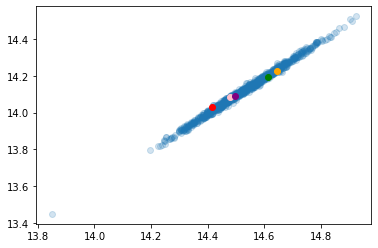

In [54]:
plt.scatter(sbp_std_edited[523.0][5:,], sbp_std_edited[102.0][5:,], alpha=0.2)
plt.scatter(sbp_std_edited[523.0][0], sbp_std_edited[102.0][0], c='red')
plt.scatter(sbp_std_edited[523.0][1], sbp_std_edited[102.0][1], c='pink')
plt.scatter(sbp_std_edited[523.0][2], sbp_std_edited[102.0][2], c='green')
plt.scatter(sbp_std_edited[523.0][3], sbp_std_edited[102.0][3], c='orange')
plt.scatter(sbp_std_edited[523.0][4], sbp_std_edited[102.0][4], c='purple')